# Task 2

Importiamo df_test_aggregated.pkl

In [96]:
import os
import pandas as pd

path_dataframes = os.path.join("..", "dataset", "dataframes")
file_path = os.path.join(path_dataframes, "test_data_aggregated.pkl")

df_test_aggregated = pd.read_pickle(file_path)

print("Il Dataframe test_data_aggregated.pkl è il seguente:")
print(df_test_aggregated.head())

print("\nLa dimensione è:", df_test_aggregated.shape)

Il Dataframe test_data_aggregated.pkl è il seguente:
   P1_time_mean  P1_time_median  P1_time_p25  P1_time_p75  P1_time_variance  \
0      1.984422        1.965596     1.898145     2.057667          0.090330   
1      1.984932        1.959335     1.893304     2.062764          0.093511   
2      1.984972        1.959743     1.893367     2.058572          0.095046   
3      1.985002        1.956308     1.893223     2.058859          0.095035   
4      1.984954        1.959155     1.893371     2.058777          0.095023   

   P1_time_line_integral  P1_time_min  P1_time_max  P1_freq_peak_value  \
0            2381.280903     0.561754     4.411926        10735.216150   
1            2381.879996     0.453799     4.103312        10976.103217   
2            2381.927644     0.436712     4.262760        11079.034425   
3            2381.962902     0.442751     4.279393        11076.215410   
4            2381.905815     0.437060     4.270896        11079.884937   

   P1_freq_peak_freq  ...  

### Step 1: predirre le etichette per i dati di test (in test_data_aggregated)

Vado a predirre le etichette di Condition (0 o 1) per i dati di test che non risultano etichettati, e questo lo vado a fare grazie al modello pre-addestrato nel Task 1 (Random Forest)

Importiamo il modello Random Forest del Task 1

In [97]:
import pickle

with open("../task1/rf_model.pkl", "rb") as f:
    rf_model = pickle.load(f)

Creo il DataFrame di feature eliminando la colonna "Case" (non serve per le predizioni)

In [98]:
df_test_features = df_test_aggregated.drop(columns=["Case"])

Uso il modello per fare le predizioni sul DataFrame di feature

In [99]:
predictions = rf_model.predict(df_test_features)

Aggiungiamo le predizioni al DataFrame df_test_aggregated

In [100]:
df_test_aggregated["Predicted_BinaryCondition"] = predictions

Esportiamo df_test_aggregated_labeled in .csv e .pkl

In [64]:
#df_test_aggregated.to_csv("../dataset/dataframes/test_data_aggregated_labeled.csv", index=False)
#df_test_aggregated.to_pickle("../dataset/dataframes/test_data_aggregated_labeled.pkl")

## Step 2: Clustering degli Anomaly Test Data (dove Condition == 1) in Unknown Anomaly e Known Anomaly

Filtro il DataFrame per mantenere solo le righe dove Predicted_BinaryCondition è 1

In [101]:
df_filtered = df_test_aggregated[df_test_aggregated["Predicted_BinaryCondition"] == 1]

### Step 2.1: Clustering utilizzando due feature

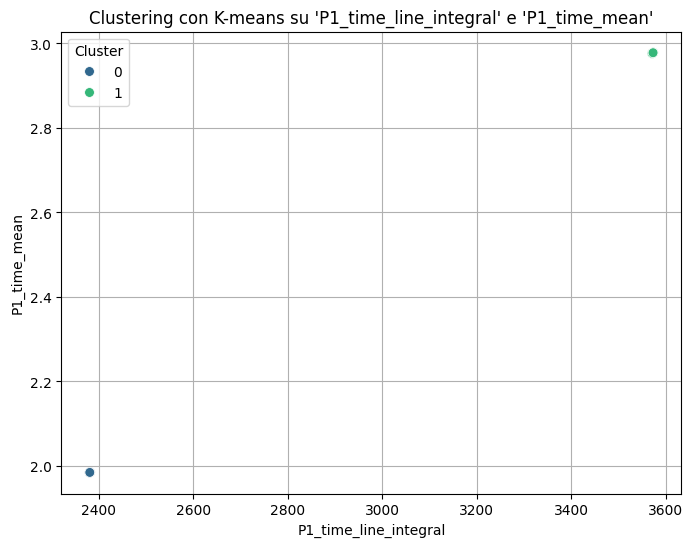

Silhouette (2 feature): 0.9994182362722046


In [102]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Assumiamo che df_filtered contenga le feature originali.
# Se esiste già una colonna 'Cluster', la rimuoviamo
if 'Cluster' in df_filtered.columns:
    df_filtered = df_filtered.drop(columns=['Cluster'])

# 1. Standardizza il dataset completo
scaler_full = StandardScaler()
X_scaled = scaler_full.fit_transform(df_filtered)

# 2. Applica k-means sull'intero dataset standardizzato per ottenere i centroidi
kmeans_full = KMeans(n_clusters=2, random_state=42)
clusters_full = kmeans_full.fit_predict(X_scaled)

# I centroidi sono nello spazio standardizzato
centroids = kmeans_full.cluster_centers_

# 3. Calcola, per ciascuna feature, la differenza assoluta tra i centroidi
feature_names = df_filtered.columns  # elenco delle feature originali
diff = np.abs(centroids[0] - centroids[1])
feature_diff = pd.Series(diff, index=feature_names)

# Seleziona le due feature migliori
top_features = feature_diff.sort_values(ascending=False)

best_feature1 = top_features.index[0]
best_feature2 = top_features.index[1]

# 5. Estrai i dati relativi alle due feature selezionate
X_two = df_filtered[[best_feature1, best_feature2]]

# Standardizza solo queste due feature
scaler_two = StandardScaler()
X_two_scaled = scaler_two.fit_transform(X_two)

# 6. Applica k-means solo sulle due feature selezionate
kmeans_two = KMeans(n_clusters=2, random_state=42)
clusters_two = kmeans_two.fit_predict(X_two_scaled)

# Aggiungi i cluster al DataFrame delle due feature
df_two = X_two.copy()
df_two['Cluster'] = clusters_two

# 7. Visualizza il clustering in un grafico scatter 2D
plt.figure(figsize=(8,6))
sns.scatterplot(x=best_feature1, y=best_feature2, hue='Cluster', data=df_two, palette='viridis', s=50)
plt.title(f"Clustering con K-means su '{best_feature1}' e '{best_feature2}'")
plt.xlabel(best_feature1)
plt.ylabel(best_feature2)
plt.grid(True)
plt.show()

#Verifichiamo la bontà del clustering con il calcolo della silhouette
from sklearn.metrics import silhouette_score
sil_score = silhouette_score(X_two_scaled, clusters_two)
print("Silhouette (2 feature):", sil_score)

In [103]:
df_clusters = df_filtered.copy()
df_clusters['Cluster'] = clusters_two

In [106]:
df_clusters[["Case","Cluster"]]

,Case,Cluster
0,178,0
1,179,0
6,184,1
8,186,0
10,188,0
12,190,0
14,192,1
15,193,0
18,196,0
19,197,0


### Step 2.2: Clustering con PCA

Elimino dal df_filtered le due colonne 'Case' e 'Predicted_BinaryCondition'

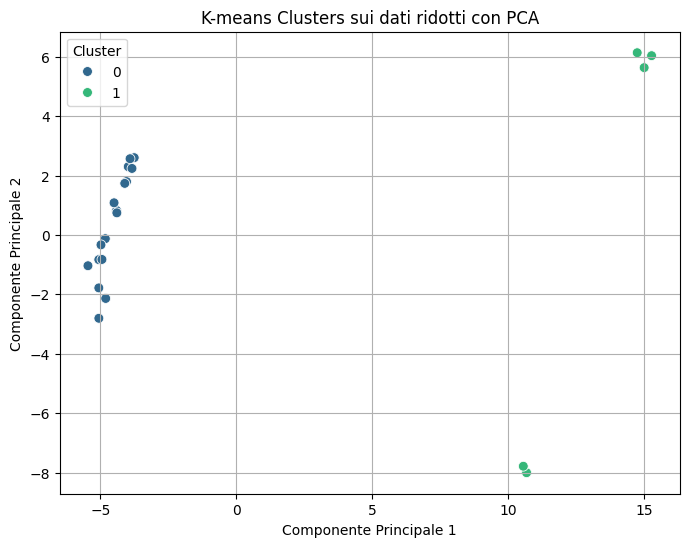

Silhouette Score (PCA): 0.7924131031442532


In [ ]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# Salva la colonna "Case" in una variabile 
cases = df_filtered["Case"].copy()

# Crea un DataFrame per il clustering escludendo le colonne "Case" e "Predicted_BinaryCondition"
df_cluster = df_filtered.drop(columns=["Case", "Predicted_BinaryCondition"])

# 1. Standardizza i dati del DataFrame per il clustering
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cluster)

# 2. Applica la PCA per ridurre la dimensionalità a 2 componenti
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# Crea un DataFrame con le componenti principali per la visualizzazione
df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'], index=df_cluster.index)

# 3. Applica k-means sui dati ridotti
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(X_pca)

# Aggiungi l'assegnazione dei cluster al DataFrame PCA
df_pca['Cluster'] = clusters

# 4. Riaggiungi la colonna "Case" al DataFrame dei risultati
df_pca['Case'] = cases.values

# 5. Visualizza i cluster su un grafico scatter
plt.figure(figsize=(8,6))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=df_pca, palette='viridis', s=50)
plt.title("K-means Clusters sui dati ridotti con PCA")
plt.xlabel("Componente Principale 1")
plt.ylabel("Componente Principale 2")
plt.grid(True)
plt.show()

# Calcola e stampa la silhouette score
sil_score = silhouette_score(X_pca, clusters)
print("Silhouette Score (PCA):", sil_score)

In [111]:
df_pca[["Case", "Cluster"]]

,Case,Cluster
0,178,0
1,179,0
6,184,1
8,186,0
10,188,0
12,190,0
14,192,1
15,193,0
18,196,0
19,197,0


## Step 3: Addestrare un classificatore che discrimini i Known Fault (tra Bubble Contamination e Solenoid Valve Fault) 

In [120]:
path_dataframes = os.path.join("..", "dataset", "dataframes")
file_path = os.path.join(path_dataframes, "train_data_aggregated.pkl")

df_train_aggregated = pd.read_pickle(file_path)

print("Il Dataframe train_data_aggregated.pkl è il seguente:")
print(df_train_aggregated.head())

print("\nLa dimensione è:", df_train_aggregated.shape)

Il Dataframe train_data_aggregated.pkl è il seguente:
   Spacecraft Condition  SV1  SV2  SV3  SV4 BP1 BP2 BP3 BP4  ...  \
0           1    Normal  100  100  100  100  No  No  No  No  ...   
1           1    Normal  100  100  100  100  No  No  No  No  ...   
2           1    Normal  100  100  100  100  No  No  No  No  ...   
3           1    Normal  100  100  100  100  No  No  No  No  ...   
4           1    Normal  100  100  100  100  No  No  No  No  ...   

  P7_time_variance P7_time_line_integral P7_time_min P7_time_max  \
0         0.329054           2366.012724   -0.003006    5.017115   
1         0.335404           2366.376508   -0.003786    4.999330   
2         0.353392           2368.725329   -0.007141    5.000936   
3         0.321221           2365.701657   -0.002395    5.008294   
4         0.324006           2366.740718   -0.002607    4.998044   

   P7_freq_peak_value  P7_freq_peak_freq  P7_freq_sum_power_spectrum  \
0        47260.680479          64.945878               2

Lasciamo solo le colonne che servono

In [121]:
df_train_aggregated = df_train_aggregated.drop(['Spacecraft','SV1', 'SV2', 'SV3', 'SV4', 'BP1', 'BP2', 'BP3', 'BP4', 'BP5', 'BP6', 'BP7', 'BV1'], axis=1)
df_train_aggregated

,Condition,P1_time_mean,P1_time_median,P1_time_p25,P1_time_p75,P1_time_variance,P1_time_line_integral,P1_time_min,P1_time_max,P1_freq_peak_value,...,P7_time_variance,P7_time_line_integral,P7_time_min,P7_time_max,P7_freq_peak_value,P7_freq_peak_freq,P7_freq_sum_power_spectrum,P7_freq_std_power_spectrum,P7_freq_rms_freq,Case
0,Normal,1.984867,1.956786,1.893564,2.059497,0.095105,2381.801118,0.436248,4.228663,11082.681127,...,0.329054,2366.012724,-0.003006,5.017115,47260.680479,64.945878,237314.084554,2632.685347,19.887772,1
1,Normal,1.984931,1.957459,1.893815,2.058403,0.095169,2381.877644,0.436435,4.256737,11086.890983,...,0.335404,2366.376508,-0.003786,4.999330,47662.864823,64.945878,241893.822061,2688.225229,20.078754,2
2,Normal,1.984999,1.960032,1.892870,2.058726,0.095117,2381.960243,0.436793,4.295627,11083.738684,...,0.353392,2368.725329,-0.007141,5.000936,46019.998152,64.945878,254866.442384,2743.060363,20.610129,3
3,Normal,1.984965,1.958703,1.893398,2.058818,0.095026,2381.919339,0.437050,4.295622,11082.002496,...,0.321221,2365.701657,-0.002395,5.008294,46367.986582,64.945878,231664.969366,2565.994380,19.649638,4
4,Normal,1.984987,1.958311,1.893440,2.059063,0.095051,2381.945830,0.437011,4.281213,11084.566826,...,0.324006,2366.740718,-0.002607,4.998044,46805.662115,64.945878,233673.009183,2592.227655,19.734615,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172,Anomaly,1.984983,1.956329,1.890819,2.065815,0.077401,2381.965861,0.543228,4.016765,10790.870749,...,0.307552,2361.961235,0.000442,4.918386,35087.812714,59.950042,221806.924274,2048.184913,19.227018,173
173,Anomaly,1.984349,1.965884,1.897594,2.053114,0.077318,2381.180062,0.820108,4.063794,8209.481967,...,0.387815,2363.165121,-0.015324,5.228732,28697.613718,62.447960,279692.093116,2114.129783,21.590588,174
174,Anomaly,1.984209,1.971360,1.894357,2.062763,0.075118,2381.054955,0.522027,4.182883,8830.192756,...,0.346742,2364.069197,0.001778,5.513235,34926.326106,59.950042,250070.258482,1959.034040,20.415283,175
175,Anomaly,1.985246,1.976075,1.895262,2.058983,0.073795,2382.298784,0.579673,4.103252,7229.156634,...,0.347191,2371.499487,0.266158,4.747359,50273.765483,59.950042,250394.249590,2615.638149,20.428503,176


Togliamo le righe con Condition == Normal

In [122]:
df_train_aggregated = df_train_aggregated[df_train_aggregated['Condition'] != 'Normal']
df_train_aggregated

,Condition,P1_time_mean,P1_time_median,P1_time_p25,P1_time_p75,P1_time_variance,P1_time_line_integral,P1_time_min,P1_time_max,P1_freq_peak_value,...,P7_time_variance,P7_time_line_integral,P7_time_min,P7_time_max,P7_freq_peak_value,P7_freq_peak_freq,P7_freq_sum_power_spectrum,P7_freq_std_power_spectrum,P7_freq_rms_freq,Case
105,Fault,1.991155,1.962412,1.929011,2.062337,0.063614,2389.358977,0.671432,3.698227,7825.968237,...,0.261037,2370.770727,-0.000892,5.024811,30854.698537,64.945878,188259.795984,1955.333379,17.713450,106
106,Fault,1.984816,1.958316,1.893118,2.062749,0.095209,2381.740580,0.349958,4.134666,10964.480139,...,0.327092,2366.290453,-0.002196,5.134264,45735.930228,64.945878,235899.122421,2577.031563,19.828394,107
107,Fault,1.984859,1.958311,1.893420,2.062896,0.095110,2381.791821,0.395507,4.218634,11055.424309,...,0.329598,2364.524645,-0.002278,5.061238,44520.555825,64.945878,237706.006104,2546.906548,19.904187,108
108,Fault,1.984876,1.959716,1.892454,2.060121,0.095042,2381.811852,0.422823,4.262273,11070.769992,...,0.328645,2365.911113,-0.002584,5.029750,46638.531350,64.945878,237018.764171,2608.912940,19.875394,109
109,Fault,1.990805,1.965620,1.929174,2.057307,0.059352,2388.937910,0.816299,3.728623,7794.772183,...,0.257265,2372.113152,-0.001875,5.064965,31975.322168,64.945878,185539.942404,1937.169148,17.585029,110
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172,Anomaly,1.984983,1.956329,1.890819,2.065815,0.077401,2381.965861,0.543228,4.016765,10790.870749,...,0.307552,2361.961235,0.000442,4.918386,35087.812714,59.950042,221806.924274,2048.184913,19.227018,173
173,Anomaly,1.984349,1.965884,1.897594,2.053114,0.077318,2381.180062,0.820108,4.063794,8209.481967,...,0.387815,2363.165121,-0.015324,5.228732,28697.613718,62.447960,279692.093116,2114.129783,21.590588,174
174,Anomaly,1.984209,1.971360,1.894357,2.062763,0.075118,2381.054955,0.522027,4.182883,8830.192756,...,0.346742,2364.069197,0.001778,5.513235,34926.326106,59.950042,250070.258482,1959.034040,20.415283,175
175,Anomaly,1.985246,1.976075,1.895262,2.058983,0.073795,2382.298784,0.579673,4.103252,7229.156634,...,0.347191,2371.499487,0.266158,4.747359,50273.765483,59.950042,250394.249590,2615.638149,20.428503,176


In [128]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Supponiamo che df_train_aggregated sia già caricato nel workspace
# e che contenga la colonna "Condition" (target) e le altre colonne come feature.

# 1. Separazione delle feature e del target
X = df_train_aggregated.drop(columns=["Condition", "Case"])
y = df_train_aggregated["Condition"]

Seleziona le migliori 20 feature usando SelectKBest con f_classif

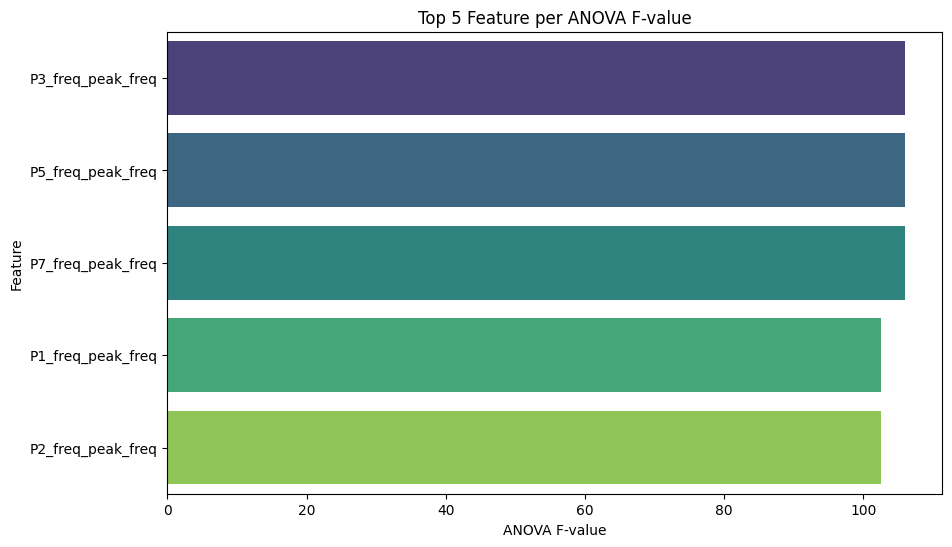

In [130]:
selector = SelectKBest(score_func=f_classif, k=5)
X_selected = selector.fit_transform(X, y)
selected_features = X.columns[selector.get_support()]

# Creiamo una Series con tutti gli F-value
f_values_all = pd.Series(selector.scores_, index=X.columns)
# Estraiamo solo quelli delle feature selezionate e li ordiniamo in ordine decrescente
f_values_top5 = f_values_all[selected_features].sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=f_values_top5.values, y=f_values_top5.index, hue=f_values_top5.index, palette='viridis', dodge=False)
plt.xlabel("ANOVA F-value")
plt.ylabel("Feature")
plt.title("Top 5 Feature per ANOVA F-value")
plt.show()

Procediamo con l'addestramento del classificatore binario con Random Forest

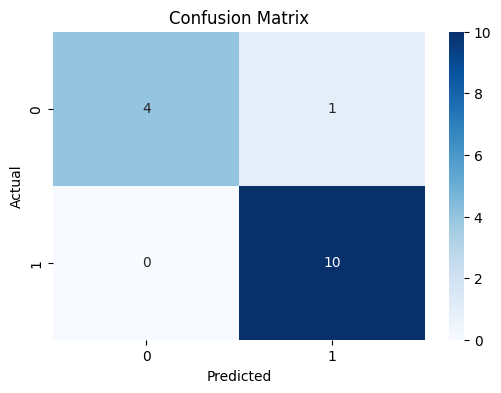


Classification Report:
              precision    recall  f1-score   support

     Anomaly       1.00      0.80      0.89         5
       Fault       0.91      1.00      0.95        10

    accuracy                           0.93        15
   macro avg       0.95      0.90      0.92        15
weighted avg       0.94      0.93      0.93        15



In [132]:
# 4. Suddividi il dataset in training e test set (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.2, random_state=42, stratify=y
)

# 5. Addestra il classificatore Random Forest sul training set
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# 6. Prevedi sul test set e calcola le metriche
y_pred = rf_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Esportiamo il modello in formato .pkl

In [133]:
import pickle

with open("fault_vs_anomaly_classifier.pkl", "wb") as f:
    pickle.dump(rf_model, f)

## Step 4: Predizione dei tipi di Fault nei casi di test (178-223)

In [134]:
df_test_aggregated

,P1_time_mean,P1_time_median,P1_time_p25,P1_time_p75,P1_time_variance,P1_time_line_integral,P1_time_min,P1_time_max,P1_freq_peak_value,P1_freq_peak_freq,...,P7_time_line_integral,P7_time_min,P7_time_max,P7_freq_peak_value,P7_freq_peak_freq,P7_freq_sum_power_spectrum,P7_freq_std_power_spectrum,P7_freq_rms_freq,Case,Predicted_BinaryCondition
0,1.984422,1.965596,1.898145,2.057667,0.090330,2381.280903,0.561754,4.411926,10735.216150,62.447960,...,2366.205104,-0.003637,4.960276,34566.752154,62.447960,217794.811254,2084.029330,19.052332,178,1
1,1.984932,1.959335,1.893304,2.062764,0.093511,2381.879996,0.453799,4.103312,10976.103217,64.945878,...,2366.481721,-0.002775,5.085864,46662.202025,64.945878,237456.962256,2617.500682,19.893758,179,1
2,1.984972,1.959743,1.893367,2.058572,0.095046,2381.927644,0.436712,4.262760,11079.034425,64.945878,...,2359.785795,-0.005444,5.001972,42644.957266,64.945878,240014.559545,2464.044767,20.000607,180,0
3,1.985002,1.956308,1.893223,2.058859,0.095035,2381.962902,0.442751,4.279393,11076.215410,64.945878,...,2366.904783,-0.004231,4.994317,42751.547033,64.945878,241495.688559,2579.566737,20.062224,181,0
4,1.984954,1.959155,1.893371,2.058777,0.095023,2381.905815,0.437060,4.270896,11079.884937,64.945878,...,2366.746214,-0.004208,4.998432,43367.818082,64.945878,237065.315657,2516.697697,19.877345,182,0
5,1.984890,1.958247,1.893337,2.058632,0.095016,2381.829597,0.436635,4.238379,11080.971005,64.945878,...,2365.259916,-0.002406,5.017334,46083.586748,64.945878,233734.612294,2564.476220,19.737216,183,0
6,2.976179,2.974052,2.870958,3.064182,0.106137,3571.409382,1.411117,5.319466,10843.669116,42.464613,...,3556.177745,0.865684,5.727131,38622.068955,42.464613,235581.008352,2539.558675,19.815020,184,1
7,1.984882,1.957307,1.893491,2.058834,0.095055,2381.818916,0.436636,4.233074,11080.856682,64.945878,...,2366.758305,-0.002392,5.011322,45291.295002,64.945878,236554.662003,2561.119518,19.855925,185,0
8,1.984192,1.960871,1.892085,2.064041,0.079165,2381.034888,0.525377,4.156134,10324.925235,59.950042,...,2363.402346,-0.001868,5.667324,46027.696112,59.950042,265146.017033,2473.864388,21.021656,186,1
9,1.984911,1.957423,1.893349,2.058631,0.095075,2381.854846,0.436629,4.267636,11084.936688,64.945878,...,2364.507660,-0.002134,5.015618,46056.713430,64.945878,230920.452143,2553.225711,19.618038,187,0


In [135]:
# 1. Fai una copia del DataFrame df_test_aggregated e assegnala a df_test_filtered
df_test_filtered = df_test_aggregated.copy()

# 2. Effettua il join con df_clusters utilizzando la colonna "Case"
df_joined = pd.merge(df_test_filtered, df_clusters[['Case', 'Cluster']], on='Case', how='left')

# 3. Filtra le righe in cui il valore della colonna "Cluster" è 0
df_test_filtered = df_joined[df_joined['Cluster'] == 0]

df_test_filtered

,P1_time_mean,P1_time_median,P1_time_p25,P1_time_p75,P1_time_variance,P1_time_line_integral,P1_time_min,P1_time_max,P1_freq_peak_value,P1_freq_peak_freq,...,P7_time_min,P7_time_max,P7_freq_peak_value,P7_freq_peak_freq,P7_freq_sum_power_spectrum,P7_freq_std_power_spectrum,P7_freq_rms_freq,Case,Predicted_BinaryCondition,Cluster
0,1.984422,1.965596,1.898145,2.057667,0.090330,2381.280903,0.561754,4.411926,10735.216150,62.447960,...,-0.003637,4.960276,34566.752154,62.447960,217794.811254,2084.029330,19.052332,178,1,0.0
1,1.984932,1.959335,1.893304,2.062764,0.093511,2381.879996,0.453799,4.103312,10976.103217,64.945878,...,-0.002775,5.085864,46662.202025,64.945878,237456.962256,2617.500682,19.893758,179,1,0.0
8,1.984192,1.960871,1.892085,2.064041,0.079165,2381.034888,0.525377,4.156134,10324.925235,59.950042,...,-0.001868,5.667324,46027.696112,59.950042,265146.017033,2473.864388,21.021656,186,1,0.0
10,1.984494,1.960064,1.892488,2.062226,0.092402,2381.355854,0.251441,4.061753,10576.765488,64.945878,...,-0.001705,5.309122,45730.645223,64.945878,238042.484593,2585.173470,19.918270,188,1,0.0
12,1.984945,1.958735,1.892944,2.062354,0.094568,2381.895127,0.438743,4.274295,11078.754688,64.945878,...,0.011023,4.964566,46544.956754,64.945878,240626.271372,2650.561382,20.026078,190,1,0.0
15,1.984388,1.955877,1.892326,2.059586,0.094680,2381.255100,0.598692,4.379292,10802.636968,64.945878,...,0.000599,5.019550,39642.577062,64.945878,226086.946314,2412.014375,19.411635,193,1,0.0
18,1.984876,1.961548,1.893872,2.055809,0.085274,2381.837115,0.543228,4.451440,9475.374287,59.950042,...,0.011591,5.006715,32312.378412,59.950042,216228.884135,1921.560558,18.983716,196,1,0.0
19,1.985009,1.969709,1.893736,2.063729,0.077480,2382.017506,0.581277,4.035789,9731.493098,59.950042,...,0.349584,5.381372,66135.809773,59.950042,279397.458219,3297.805389,21.579213,197,1,0.0
24,1.984803,1.955662,1.891361,2.064053,0.091184,2381.721987,0.445244,4.447171,11034.864811,64.945878,...,0.000629,4.927365,46226.764883,64.945878,233012.383268,2539.372690,19.706699,202,1,0.0
26,1.984459,1.963269,1.896229,2.057770,0.085698,2381.312305,0.409866,4.300450,8590.029510,62.447960,...,-0.004429,4.956197,27789.660184,59.950042,205414.108859,1974.061537,18.502888,204,1,0.0


In [138]:
# Estrai dal DataFrame di test solo le feature utilizzate per l'addestramento
X_test_pred = df_test_filtered[selected_features]

# Esegui le predizioni: il modello restituirà per ogni riga il valore predetto ("Fault" o "Anomaly")
predictions = rf_model.predict(X_test_pred)

# Aggiungi il risultato al DataFrame in una nuova colonna "Predicted_Condition"
df_test_filtered.loc[:, "Predicted_Condition"] = predictions
df_test_filtered[['Case', 'Predicted_Condition']]

/Users/davidedegrazia/Desktop/C2_PHM_AsiaPacific_2023/phm_env/lib/python3.13/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


,Case,Predicted_Condition
0,178,Anomaly
1,179,Fault
8,186,Anomaly
10,188,Fault
12,190,Fault
15,193,Fault
18,196,Anomaly
19,197,Anomaly
24,202,Fault
26,204,Anomaly


## Step 5: Risultato finale

In [143]:
# Filtra df_clusters per ottenere solo le righe dove Cluster è 1
df_clusters_1 = df_clusters[df_clusters["Cluster"] == 1].copy()

# Crea un nuovo DataFrame con le colonne "Case" e "Predicted_Condition"
df_new_rows = df_clusters_1[["Case"]].copy()
df_new_rows.loc[:, "Predicted_Condition"] = "Unknown"

# Ora concatena df_test_filtered con il nuovo DataFrame
df_result = pd.concat([df_test_filtered, df_new_rows], ignore_index=True)

# Case crescente
df_result = df_result.sort_values(by='Case', ascending=True)

#Togliamo le colonne che non servono
df_result = df_result[['Case', 'Predicted_Condition']]
df_result

,Case,Predicted_Condition
0,178,Anomaly
1,179,Fault
17,184,Unknown
2,186,Anomaly
3,188,Fault
4,190,Fault
18,192,Unknown
5,193,Fault
6,196,Anomaly
7,197,Anomaly


In [145]:
# 1. Filtra df_test_aggregated per le righe con Predicted_BinaryCondition == 0
df_normal = df_test_aggregated[df_test_aggregated['Predicted_BinaryCondition'] == 0].copy()

# 2. Seleziona solo la colonna "Case" e aggiungi una nuova colonna "Predicted_Condition" con valore "Normal"
df_normal = df_normal[['Case']].copy()
df_normal.loc[:, "Predicted_Condition"] = "Normal"

# 3. Concatena df_normal a df_result
df_result = pd.concat([df_result, df_normal], ignore_index=True)

# 4. Ordina df_result per la colonna "Case" in ordine crescente
df_result = df_result.sort_values(by='Case', ascending=True)

df_result

,Case,Predicted_Condition
0,178,Anomaly
1,179,Fault
23,180,Normal
24,181,Normal
25,182,Normal
26,183,Normal
2,184,Unknown
27,185,Normal
3,186,Anomaly
28,187,Normal
